In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

#### First task: load the required data and match up the catalogues

In [2]:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [3]:
gz2_stats = Table.read('fits/gz2_statistics.fits')
sparcfire_matched = Table.read('fits/galaxy_level_matched.fits')
ml_table_matched = Table.read('fits/ml_table_matched.fits')

In [4]:
sample_ok = ml_table_matched['vmax_ok']
sparcfire_ok = sparcfire_matched['N_arcs'] > 0
print('{} in initial sample --> {} in sparcfire'.format(sample_ok.sum(),
                                         (sample_ok*sparcfire_ok).sum()))

sparcfire_sample_ok = np.all([sparcfire_ok,sample_ok],axis=0)

6222 in initial sample --> 3028 in sparcfire


In [6]:
gz2_stats['p_bar'] = gz2_data['t03_bar_a06_bar_debiased_rh']
# define some classes:
# 1 = m=2, unbarred
# 2 = m=2, barred
# 3 = m>2, unbarred
# 4 = m>2, barred

plot_class = np.zeros(len(gz2_stats))
plot_class[(gz2_stats['m'] == 2) 
         & (gz2_stats['p_bar'] <= 0.5)] = 1
plot_class[(gz2_stats['m'] == 2) 
         & (gz2_stats['p_bar'] > 0.5)] = 2
plot_class[(gz2_stats['m'] > 2) 
         & (gz2_stats['p_bar'] <= 0.5)] = 3
plot_class[(gz2_stats['m'] > 2) 
         & (gz2_stats['p_bar'] > 0.5)] = 4

gz2_stats['plot_class'] = plot_class

#### First task: what do the pitch angle distributions _look_ like?

In [7]:
# Get some galaxy distributions to compare to

s4g_galaxies = Table.read('../fits/S4G/s4g_arms_galaxy.fits')
s4g_psi = np.array(s4g_galaxies['P_abs'])

seigar_06 = [8.4,25.2,25.7,18,26.4,46.4,17.6,31.1,15.7,50.3,31.7,48.8,42.1,
             20.3,26.4,46.9,10.7,21.2,13.6,24,28.1,32.5,21.7,15.3,32,31,
             24.9,18.2,35.7,19.8,18.3,43.3,13.2,24.8,22.1,32.1,40.4,22.4,
             17.8,49.3,16.3,49.5,38.7,29.6,25.1,36.7,40.4,26.2,17.8,20.3,
             24.9,29.4,22.3,17.8,19.3,16.1,28.5,
             38.8,13.8,27.6,24.2,24,14.1,36.9,9.1,8.9]

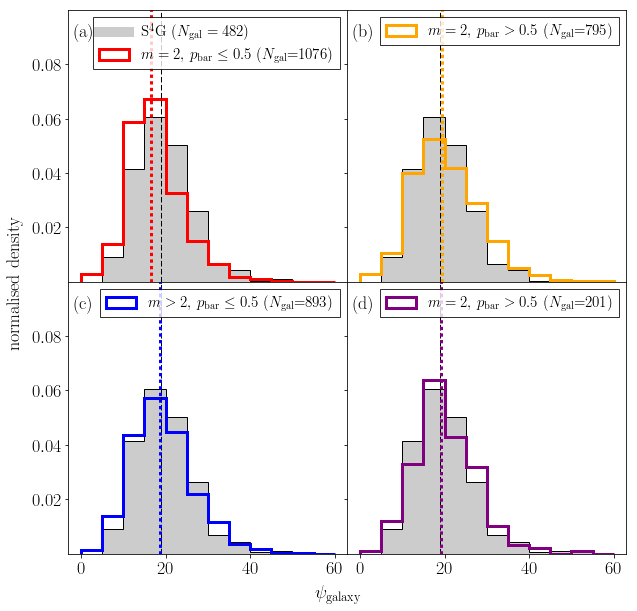

In [15]:
fig, axarr = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)
axarr = axarr.ravel()
fig.subplots_adjust(hspace=0,wspace=0)

colors = ('red','orange','blue','purple')
classlabels = ('$m=2$, $p_\mathrm{bar} \leq 0.5$',
               '$m=2$, $p_\mathrm{bar} > 0.5$',
               '$m>2$, $p_\mathrm{bar} \leq0.5$',
               '$m=2$, $p_\mathrm{bar} > 0.5$')
letters = 'abcd'

bins = np.linspace(0,60,13)

###############################

_ = axarr[0].plot([],[],color='k',alpha=0.2,lw=10,
            label='S$^4$G ($N_\mathrm{{gal}}={}$)'.format(len(s4g_psi))) 

for c, (ax, color) in enumerate(zip(axarr,colors)):
    plt.sca(ax)
    in_class = np.all([sparcfire_sample_ok,gz2_stats['plot_class'] == c+1],
                      axis=0)
    psi_c = sparcfire_matched['P_wtd_avg'][in_class]
    _ = ax.hist(s4g_psi,bins,normed=True,color='k',alpha=0.2)
    _ = ax.hist(s4g_psi,bins,normed=True,color='k',histtype='step')
    plt.axvline(np.median(s4g_psi),color='k',linestyle='dashed',lw=1)
    c_label = classlabels[c] + ' ($N_\mathrm{{gal}}$={})'.format(in_class.sum())
    _ = ax.hist(psi_c,bins,normed=True,color=color,histtype='step',lw=3,
                label=c_label)
    plt.axvline(np.median(psi_c),color=color,linestyle='dotted',lw=3)
    ax.legend(loc='upper right',fancybox=False,edgecolor='k',fontsize=15)
    _ = ax.text(0.02,0.95,'({})'.format(letters[c]),
                transform=ax.transAxes,ha='left',va='top')
    

_ = ax.set_ylim(0,0.1)   
_ = fig.text(0.5, 0.06, '$\psi_\mathrm{galaxy}$', ha='center')
_ = fig.text(0.04, 0.5, 'normalised density', va='center', rotation='vertical')

#_ = fig.savefig('paper_figures/pitch_angle_histograms.pdf')

In [17]:
print('S4G:')
print(np.percentile(s4g_psi,(16,50,84)))

print('all galaxies:')
print(np.percentile(sparcfire_matched['P_wtd_avg'][sparcfire_sample_ok],
      (16,50,84)))

S4G:
[ 13.498668  18.96335   25.733684]
all galaxies:
[ 12.17640102  18.00815773  26.12333389]


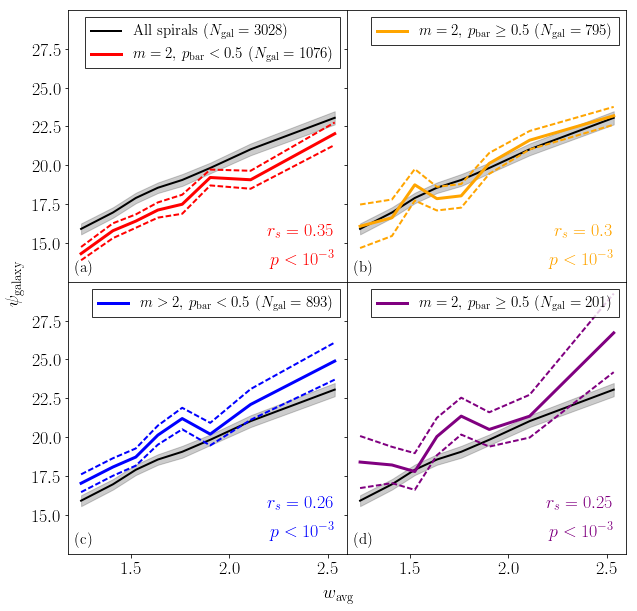

In [19]:
import xy_plots
import imp
imp.reload(xy_plots)

from bin_statistics import assign_bins
from xy_plots import x_vs_y

fig, axarr = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)
axarr = axarr.ravel()
fig.subplots_adjust(hspace=0,wspace=0)

###############################
sample_bins = assign_bins(gz2_stats['w_wtd_avg'][sparcfire_sample_ok],
                          equal_N=True,N_bins=8)
galaxy_bins = np.zeros(len(gz2_stats))
galaxy_bins[sparcfire_sample_ok] = sample_bins

xy_all = x_vs_y(gz2_stats['w_wtd_avg'][sparcfire_sample_ok],
                sparcfire_matched['P_wtd_avg'][sparcfire_sample_ok])
xy_all = xy_all.continuous_vs_continuous_binned(bin_assignments=sample_bins)

axarr[0].plot([],[],color='k',lw=2,
    label='All spirals ($N_\mathrm{{gal}}={}$)'.format(sparcfire_sample_ok.sum()))

for c, (ax, color, label) in enumerate(zip(axarr,colors,classlabels)):
    xy_all.line_plot(ax,color='k',lw=2)
    xy_all.error_plot(ax,color='k',style='filled',alpha=0.2)
    
    in_class = np.all([gz2_stats['plot_class'] == c+1,sparcfire_sample_ok],
                      axis=0)
    class_bins = galaxy_bins[in_class]
    
    xy_label = label + ' ($N_\mathrm{{gal}}={}$)'.format(in_class.sum())
    xy = x_vs_y(gz2_stats['w_wtd_avg'][in_class],
                sparcfire_matched['P_wtd_avg'][in_class])
    xy = xy.continuous_vs_continuous_binned(bin_assignments=class_bins)
    xy.x_table = xy_all.x_table # for plotting
    xy.line_plot(ax,color=color,lw=3,label=xy_label)
    xy.error_plot(ax,style='lined',linestyle='dashed',lw=2,color=color)
    xy.spearmanr(ax,location='lower right',color=color,spacing=0.1)
    ax.legend(loc='upper right',fontsize=15,fancybox=False,edgecolor='k')
    ax.text(0.025,0.025,'({})'.format(letters[c]),fontsize=15,
            transform=ax.transAxes,va='bottom',ha='left')

_ = fig.text(0.5, 0.06,'$w_\mathrm{avg}$', ha='center')
_ = fig.text(0.04, 0.5,r'$\psi_\mathrm{galaxy}$', va='center', rotation='vertical')
_ = ax.set_ylim(12.5,30)

#fig.savefig('paper_figures/w_avg_vs_P.pdf')

In [20]:
print(xy_all.spearmanr(None,plot=False,printout=True))

$r_s = 0.3$ $p < 10^{-3}$
None


#### Next task: compare spiral arm number and pitch angle?

Here, we shall use the M*-matched sample

In [23]:
print(names_)

['m=1, b=1', 'm=2, b=1', 'm=3, b=1', 'm=4, b=1', 'm=5+, b=1', 'm=1, b=2', 'm=2, b=2', 'm=3, b=2', 'm=4, b=2', 'm=5+, b=2', 'm=1, b=3', 'm=2, b=3', 'm=3, b=3', 'm=4, b=3', 'm=5+, b=3']


In [28]:
mass_masks = Table.read('fits/mass_masks_matched.fits')

names_ = mass_masks.colnames[3:]

# ------------------------------------------------------
mass_0 = np.any([mass_masks[n] for n in names_],axis=0)
bar_0 = np.all([sparcfire_sample_ok,mass_0],axis=0)
print(bar_0.sum())
# ------------------------------------------------------
mass_1 = np.any([mass_masks[n] for n in names_[:5]],axis=0)
bar_1 = np.all([sparcfire_sample_ok,mass_1],axis=0)
print(bar_1.sum())
# ------------------------------------------------------
mass_2 = np.any([mass_masks[n] for n in names_[5:10]],axis=0)
bar_2 = np.all([sparcfire_sample_ok,mass_2],axis=0)
print(bar_02.sum())
# ------------------------------------------------------
mass_3 = np.any([mass_masks[n] for n in names_[10:15]],axis=0)
bar_3 = np.all([sparcfire_sample_ok,mass_3],axis=0)
print(bar_3.sum())
# ------------------------------------------------------

masks = [bar_0,bar_1,bar_2,bar_3]

2365
914
781
670


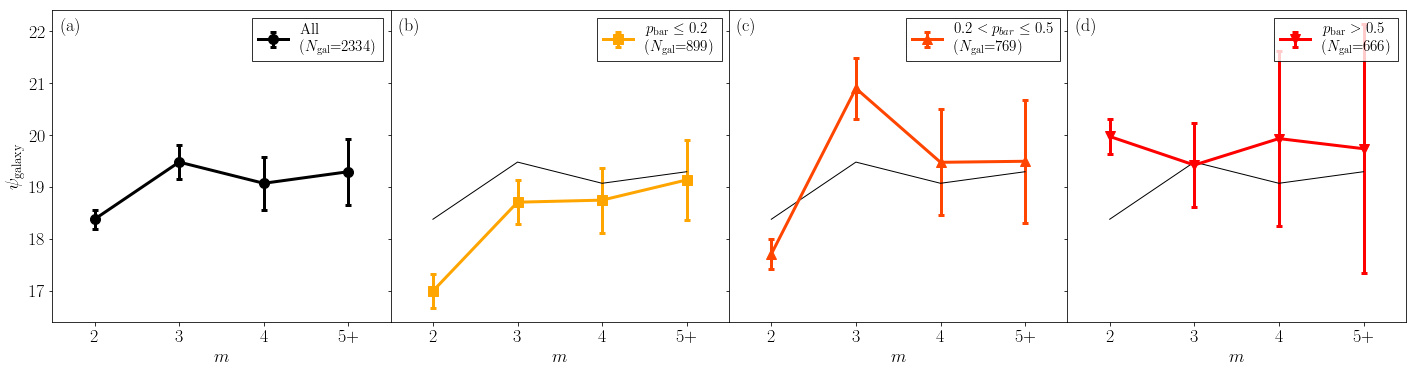

In [84]:
fig, axarr = plt.subplots(1,4,figsize=(20,5.5),
                          sharex='row',sharey='row')

colors = ('black','orange','orangered','red')
markers = ('o','s','^','v')
ticklabels = ('1','2','3','4','5+')
letters = 'abcdef'
xys = []

classlabels = ('All','$p_\mathrm{bar} \leq 0.2$',
               '$0.2 < p_{bar} \leq 0.5$', '$p_\mathrm{bar} > 0.5$')

mask_all = (masks[0]) & (gz2_stats['m'] > 1)
xy_all = x_vs_y(gz2_stats['m'][mask_all],
                sparcfire_matched['P_wtd_avg'][mask_all])
xy_all = xy_all.discrete_vs_continuous_binned()
for ax in axarr:
    xy_all.line_plot(ax,color='k',lw=1)

for mask, label, ax, color, marker, letter in zip(masks,classlabels,axarr,colors,markers,letters):
    mask_ = (mask) & (gz2_stats['m'] > 1)
    
    xy = x_vs_y(gz2_stats['m'][mask_],
                sparcfire_matched['P_wtd_avg'][mask_])
    xy = xy.discrete_vs_continuous_binned()
    xy_label = label + '\n ($N_\mathrm{{gal}}$={})'.format(mask_.sum())
    xy.error_plot(ax,color=color,style='errorbar',marker=marker,
                  markersize=10,lw=3,capsize=3,capthick=3,label=xy_label)
    #xy.spearmanr(ax,location='lower right',spacing=0.1)
    ax.legend(loc='upper right',fontsize=15,fancybox=False,edgecolor='k')
    ax.text(0.025,0.975,'({})'.format(letter),
            transform=ax.transAxes,ha='left',va='top')
    _ = ax.set_xlabel('$m$')
    xys.append(xy)
    
_ = axarr[0].set_xlim(1.5,5.5)
_ = axarr[0].set_xticks([2,3,4,5])
_ = axarr[0].set_xticklabels(ticklabels[1:])
_ = axarr[0].set_ylabel(r'$\psi_\mathrm{galaxy}$')

fig.tight_layout()
fig.subplots_adjust(wspace=0,hspace=0)
#_ = ax.set_ylim(15.5,22.5)

fig.savefig('paper_figures/m_vs_P.pdf')

In [94]:
for b in range(3):

    print(xys[b].y_table['mean'],
          xys[b].y_table['mean']-xys[b].y_table['mean-1sigma'])
    
    print('------------------------')

     mean    
-------------
 18.374285964
19.4754414521
19.0670630537
19.2901895726      mean     
--------------
0.185011008871
0.321052817984
0.512939118104
0.632871887076
------------------------
     mean    
-------------
16.9915209987
18.7029082398
18.7424516305
19.1320435642      mean     
--------------
0.322388219685
0.425764202576
0.628171625967
 0.77426564141
------------------------
     mean    
-------------
17.7031090737
20.8964384376
19.4712713118
19.4912510933      mean     
--------------
0.282088375483
0.593643811897
 1.01953323408
 1.18433462926
------------------------


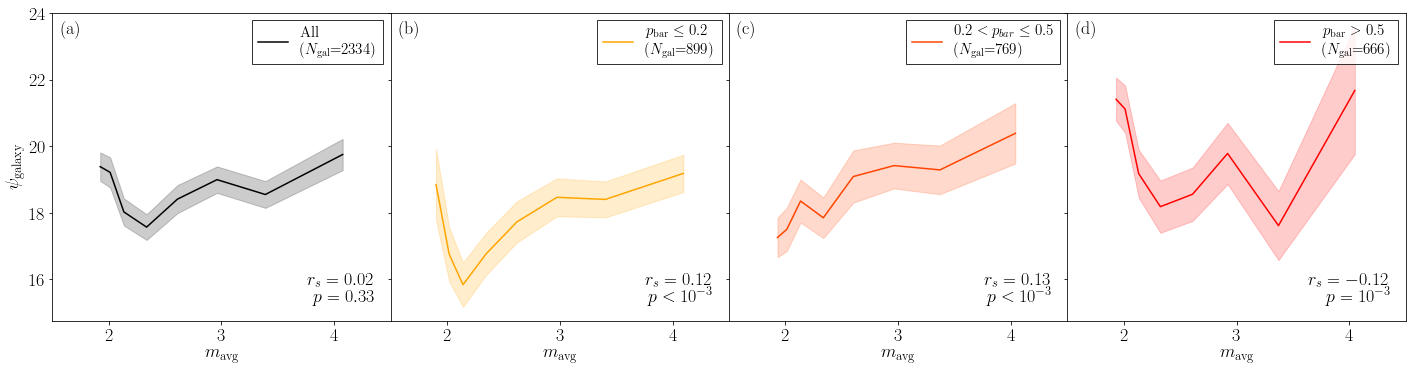

In [96]:
from bin_statistics import assign_bins

fig, axarr = plt.subplots(1,4,figsize=(20,5.5),sharex='row',sharey='row')


mask_all = (masks[0]) & (gz2_stats['m'] > 1)
bins_ = assign_bins(gz2_stats['m_wtd_avg'][mask_all],N_bins=8)
all_bins = np.ones(len(gz2_data))*(-999)
all_bins[mask_all] = bins_


for mask, label, ax, color, letter in zip(masks,classlabels,axarr,colors,letters):
    mask_ = (mask) & (gz2_stats['m'] > 1)
    #mask_ = mask
    xy = x_vs_y(gz2_stats['m_wtd_avg'][mask_],
                sparcfire_matched['P_wtd_avg'][mask_])
    
    x = gz2_stats['m_wtd_avg'][mask_]
    y = sparcfire_matched['P_wtd_avg'][mask_]
    bins = all_bins[mask_]
    xy_label = label + '\n ($N_\mathrm{{gal}}$={})'.format(mask_.sum())
    xy.spearmanr(ax,location='lower right')
    x_plot = []
    y_plot = []
    y_err = []
    for b in np.unique(bins):
        x_plot.append(np.mean(x[bins == b]))
        y_plot.append(np.mean(y[bins == b]))
        y_err.append(np.std(y[bins==b])/np.sqrt((bins == b).sum()))
    x_plot = np.array(x_plot)
    y_plot = np.array(y_plot)
    y_err = np.array(y_err)
    
    _ = ax.plot(x_plot,y_plot,
                color=color,label=xy_label)
    _ = ax.fill_between(x_plot,y_plot-y_err,y_plot+y_err,
                        color=color,alpha=0.2)
    
    ax.legend(loc='upper right',fontsize=15,fancybox=False,edgecolor='k')
    _ = ax.set_xlabel('$m_\mathrm{avg}$')
    
    ax.text(0.025,0.975,'({})'.format(letter),
            transform=ax.transAxes,ha='left',va='top')
    
_ = axarr[0].set_xlim(1,5)
_ = axarr[0].set_xticks([2,3,4])
_ = axarr[0].set_ylabel(r'$\psi_\mathrm{galaxy}$')

fig.tight_layout()
fig.subplots_adjust(wspace=0,hspace=0)
ax.set_xlim(1.5,4.5)

fig.savefig('paper_figures/m_avg_vs_P.pdf')

In [97]:
for b in range(3):

    print(xys[b].y_table['mean'],
          xys[b].y_table['mean']-xys[b].y_table['mean-1sigma'])
    
    print('------------------------')

     mean    
-------------
 18.374285964
19.4754414521
19.0670630537
19.2901895726      mean     
--------------
0.185011008871
0.321052817984
0.512939118104
0.632871887076
------------------------
     mean    
-------------
16.9915209987
18.7029082398
18.7424516305
19.1320435642      mean     
--------------
0.322388219685
0.425764202576
0.628171625967
 0.77426564141
------------------------
     mean    
-------------
17.7031090737
20.8964384376
19.4712713118
19.4912510933      mean     
--------------
0.282088375483
0.593643811897
 1.01953323408
 1.18433462926
------------------------


#### Final task: how does the presence of a bar affect the spiral arm pitch angle?

$r_s = 0.12$ $p < 10^{-3}$
$r_s = 0.2$ $p < 10^{-3}$


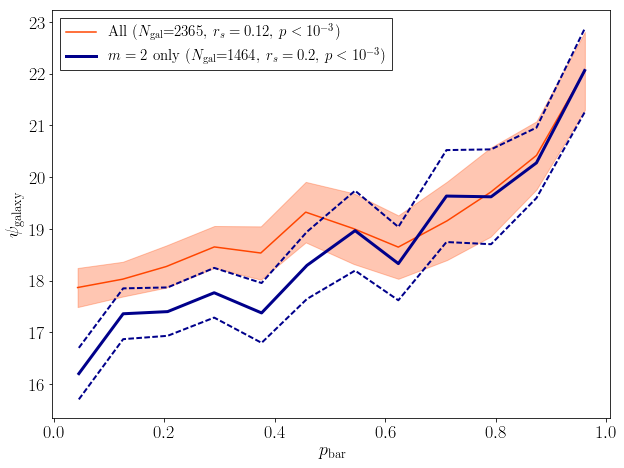

In [115]:
fig = plt.figure(figsize=(10,7.5))
ax = plt.subplot(111)

bar_sample_matched = np.all([sparcfire_sample_ok,bar_0],axis=0)
m_2_sparcfire_ok = np.all([gz2_stats['m'] == 2,bar_sample_matched],
                          axis=0)

x_all = gz2_stats['p_bar'][bar_sample_matched]
y_all = sparcfire_matched['P_wtd_avg'][bar_sample_matched]
m_2 = gz2_stats['m'][bar_sample_matched] == 2

galaxy_bins = assign_bins(gz2_stats['p_bar'][bar_sample_matched],
                          equal_N=False,N_bins=12)

xy_all = x_vs_y(x_all,y_all)
xy_all = xy_all.continuous_vs_continuous_binned(bin_assignments=galaxy_bins)
r_all, s_all = xy_all.spearmanr(ax,printout=True,plot=False)
xy_all_label='All ($N_\mathrm{{gal}}$={}, {}, {})'.format(len(x_all),r_all,s_all)
xy_all.line_plot(ax,color='orangered',label=xy_all_label)
xy_all.error_plot(ax,color='orangered',alpha=0.3,style='filled')


xy_m_2 = x_vs_y(x_all[m_2],y_all[m_2])
xy_m_2 = xy_m_2.continuous_vs_continuous_binned(bin_assignments=galaxy_bins[m_2])
r_2, s_2 = xy_m_2.spearmanr(ax,printout=True,plot=False)
xy_m_2_label='$m=2$ only ($N_\mathrm{{gal}}$={}, {}, {})'.format(m_2.sum(),r_2,s_2)
xy_m_2.line_plot(ax,color='darkblue',lw=3,label=xy_m_2_label)
xy_m_2.error_plot(ax,color='darkblue',style='lined',linestyle='dashed',lw=2)

_ = ax.legend(loc='upper left',fontsize=15,fancybox=False,edgecolor='k')

_ = ax.set_xlabel('$p_\mathrm{bar}$')
_ = ax.set_ylabel('$\psi_\mathrm{galaxy}$')

fig.savefig('paper_figures/p_bar_vs_P.pdf')

In [104]:
xy_all.spearmanr(ax,printout=True,plot=False)

$r_s = 0.12$ $p < 10^{-3}$


In [112]:
import imp
imp.reload(xy_plots)

import xy_plots
from xy_plots import x_vs_y